In [399]:
from gfn.env import DiscreteEnv
from gfn.states import DiscreteStates
import torch
from torchtyping import TensorType as TT
import random
from tqdm import tqdm
from gfn.actions import Actions
from gfn.preprocessors import Preprocessor
from gfn.states import States
import torch.nn.functional as F


In [402]:
class BoardPreprocessor(Preprocessor):
    def preprocess(self, states: States):
        batch_shape = states.tensor.shape[:-2]
        one_hot_rep = F.one_hot(states.tensor.flatten(len(batch_shape)))
        return one_hot_rep.reshape(list(batch_shape) + [-1])
    
processor = BoardPreprocessor(output_dim=256)

In [346]:
DIR_UP = 0
DIR_RIGHT = 1
DIR_DOWN = 2
DIR_LEFT = 3

def move(board, dir):
    new_board = board.clone()
    gap_coord = torch.where(new_board == 0)
    if(dir == DIR_UP and gap_coord[0] > 0):
        new_board[gap_coord[0], gap_coord[1]] = new_board[gap_coord[0]-1, gap_coord[1]] 
        new_board[gap_coord[0]-1, gap_coord[1]] = 0
    elif(dir == DIR_RIGHT and gap_coord[1] < 3):
        new_board[gap_coord[0], gap_coord[1]] = new_board[gap_coord[0], gap_coord[1]+1]
        new_board[gap_coord[0], gap_coord[1]+1] = 0
    if(dir == DIR_DOWN and gap_coord[0] < 3):
        new_board[gap_coord[0], gap_coord[1]] = new_board[gap_coord[0]+1, gap_coord[1]] 
        new_board[gap_coord[0]+1, gap_coord[1]] = 0
    elif(dir == DIR_LEFT and gap_coord[1] > 0):
        new_board[gap_coord[0], gap_coord[1]] = new_board[gap_coord[0], gap_coord[1]-1]
        new_board[gap_coord[0], gap_coord[1]-1] = 0
    return new_board

def random_board():
    board = torch.arange(0,16).reshape((4,4))
    for i in range(100):
        board = move(board, random.randint(0,3))
    return board



In [708]:
boards = torch.stack([random_board() for i in range(128)])

In [710]:
movements = torch.randint(0, 4, size=(128,10))

In [712]:
from model import BoardTransformer

In [714]:
bt = BoardTransformer(32, 8, 5, 5, 4)

In [717]:
out = bt(boards, movements)

In [718]:
out[0, -1]

tensor([0.1169, 0.4596, 0.3559, 0.0676], grad_fn=<SelectBackward0>)

In [236]:
class PuzzleGrid(DiscreteEnv):
    def __init__(
            self,
            max_steps=100,
            device='cpu',
    ):
        self.s0 = torch.zeros(max_steps, dtype=torch.int, device=torch.device(device))
        self.device = device
        self.max_steps = max_steps
        super().__init__(
            n_actions=4,
            s0=self.s0,
            preprocessor=BoardPreprocessor(output_dim=256),
        )
        
    def make_States_class(self) -> type[DiscreteStates]:
        class GameStates(DiscreteStates):
            state_shape = (4,4)
            s0 = self.s0
            n_actions = 4
            device = self.device

            @classmethod
            def make_random_states_tensor(cls, batch_shape: tuple[int]) -> TT:
                return torch.stack([random_board() for i in range(100)]).reshape(list(batch_shape) + [4,4])

    def maskless_step(self, states: DiscreteStates, actions: Actions):
        pass                                                                                                                                                        3
    
    def true_reward(self, final_states: DiscreteStates):
        batch_shape = final_states.tensor.shape[:-2]
        ground_truth = torch.arange(16).reshape(4,4).expand_as(final_states.tensor)
        diff = final_states.tensor - ground_truth
        return (diff == 0).reshape(list(batch_shape) + [-1]).count_nonzero(dim=2)
        

In [152]:
class GameBoard:
    def __init__(self, dims):
        n_entries = dims[0] * dims[1]
        n_entries = 16
        self.board = torch.arange(0,n_entries).reshape(dims)
        self.curr_empty = (0,0)

    def move(self, axis, magn):
        gap_coord = torch.where(self.board == 0)
        if(axis not in [0,1] or magn not in [0,1,2,3]):
            return
        
        if(axis == 0):
            if(magn > gap_coord[0]):
                for i in range(gap_coord[0], magn):
                    self.board[i,gap_coord[1]] = self.board[i+1, gap_coord[1]]
                self.board[magn, gap_coord[1]] = 0

            if(magn < gap_coord[0]):
                for i in range(gap_coord[0], magn, -1):
                    self.board[i,gap_coord[1]] = self.board[i-1, gap_coord[1]]
                self.board[magn, gap_coord[1]] = 0
            
        if(axis == 1):
            if(magn > gap_coord[1]):
                for i in range(gap_coord[1], magn):
                    self.board[gap_coord[0], i] = self.board[gap_coord[0], i+1]
                self.board[gap_coord[0], magn] = 0

            if(magn < gap_coord[1]):
                for i in range(gap_coord[1], magn, -1):
                    self.board[gap_coord[0], i] = self.board[gap_coord[0], i-1]
                self.board[gap_coord[0], magn] = 0
        

    def shuffle(self, n_moves=100):
        for _ in range(n_moves):
            self.move(random.randint(0,1), random.randint(0,3))

In [192]:
def random_board():
    board = torch.arange(0,16).reshape((4,4))
    for i in range(100):
        board = move(board,random.randint(0,1), random.randint(0,3))
    return board

In [201]:
random_board()

tensor([[ 5,  0,  2,  3],
        [13, 10, 11,  6],
        [ 1, 14, 12,  7],
        [ 4,  9,  8, 15]])

In [153]:
board = GameBoard([4,4])

In [154]:
board.shuffle(1000)

In [155]:
board.board

tensor([[ 5, 11, 14,  1],
        [ 2,  6,  4, 10],
        [ 3, 13,  0, 15],
        [12,  7,  8,  9]])

In [11]:
dims = [4,4]

In [81]:
def move(board, axis, magn):
    new_board = board.clone()
    gap_coord = torch.where(new_board == 0)
    if(axis == 0):
        if(magn > gap_coord[0]):
            for i in range(gap_coord[0], magn):
                new_board[i,gap_coord[1]] = new_board[i+1, gap_coord[1]]
            new_board[magn, gap_coord[1]] = 0

        if(magn < gap_coord[0]):
            for i in range(gap_coord[0], magn, -1):
                new_board[i,gap_coord[1]] = new_board[i-1, gap_coord[1]]
            new_board[magn, gap_coord[1]] = 0
        
    
    if(axis == 1):
        if(magn > gap_coord[1]):
            for i in range(gap_coord[1], magn):
                new_board[gap_coord[0], i] = new_board[gap_coord[0], i+1]
            new_board[gap_coord[0], magn] = 0

        if(magn < gap_coord[1]):
            for i in range(gap_coord[1], magn, -1):
                new_board[gap_coord[0], i] = new_board[gap_coord[0], i-1]
            new_board[gap_coord[0], magn] = 0
    return new_board


In [114]:
n_entries = dims[0] * dims[1]
board = torch.arange(0,n_entries).reshape(dims)
print(board)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])


In [118]:
print(board)
board = move(board, 1, 0)
print(board)

tensor([[ 1,  5,  2,  3],
        [ 4,  6,  0,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])
tensor([[ 1,  5,  2,  3],
        [ 0,  4,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])


## each move operation can be specified as
## (axis, magn) where axis=0,1 and magn=0,1,2,3.
## Along the specified axis and magnitude, the entries are moved to fill the current gap, and a new gap is created

In [159]:
import torch
from tqdm import tqdm

from gfn.gflownet import TBGFlowNet  # We use a GFlowNet with the Trajectory Balance (TB) loss
from gfn.gym import HyperGrid  # We use the hyper grid environment
from gfn.modules import DiscretePolicyEstimator
from gfn.samplers import Sampler
from gfn.utils import NeuralNet  # NeuralNet is a simple multi-layer perceptron (MLP)

if __name__ == "__main__":

    # 1 - We define the environment

    env = HyperGrid(ndim=4, height=8, R0=0.01)  # Grid of size 8x8x8x8

    # 2 - We define the needed modules (neural networks)

    # The environment has a preprocessor attribute, which is used to preprocess the state before feeding it to the policy estimator
    module_PF = NeuralNet(
        input_dim=env.preprocessor.output_dim,
        output_dim=env.n_actions
    )  # Neural network for the forward policy, with as many outputs as there are actions
    module_PB = NeuralNet(
        input_dim=env.preprocessor.output_dim,
        output_dim=env.n_actions - 1,
        torso=module_PF.torso  # We share all the parameters of P_F and P_B, except for the last layer
    )

    # 3 - We define the estimators

    pf_estimator = DiscretePolicyEstimator(module_PF, env.n_actions, is_backward=False, preprocessor=env.preprocessor)
    pb_estimator = DiscretePolicyEstimator(module_PB, env.n_actions, is_backward=True, preprocessor=env.preprocessor)

    # 4 - We define the GFlowNet

    gfn = TBGFlowNet(init_logZ=0., pf=pf_estimator, pb=pb_estimator)  # We initialize logZ to 0

    # 5 - We define the sampler and the optimizer

    sampler = Sampler(estimator=pf_estimator)  # We use an on-policy sampler, based on the forward policy

    # Policy parameters have their own LR.
    non_logz_params = [v for k, v in dict(gfn.named_parameters()).items() if k != "logZ"]
    optimizer = torch.optim.Adam(non_logz_params, lr=1e-3)

    # Log Z gets dedicated learning rate (typically higher).
    logz_params = [dict(gfn.named_parameters())["logZ"]]
    optimizer.add_param_group({"params": logz_params, "lr": 1e-1})

    # 6 - We train the GFlowNet for 1000 iterations, with 16 trajectories per iteration

    for i in (pbar := tqdm(range(1000))):
        trajectories = sampler.sample_trajectories(env=env, n_trajectories=16)
        optimizer.zero_grad()
        loss = gfn.loss(env, trajectories)
        loss.backward()
        optimizer.step()
        if i % 25 == 0:
            pbar.set_postfix({"loss": loss.item()})

  0%|          | 0/1000 [00:00<?, ?it/s]

  6%|▌         | 59/1000 [00:04<01:14, 12.63it/s, loss=1.39]


KeyboardInterrupt: 

In [174]:
states_class = env.make_States_class()
obj = states_class()

TypeError: DiscreteStates.__init__() missing 1 required positional argument: 'tensor'

In [239]:
import pandas as pd
import pyarrow
import fastparquet

In [240]:
parquet_file = "train-00000-of-00001-cced8514c7ed782a.parquet"
df = pd.read_parquet(parquet_file, engine='pyarrow')

In [260]:
df.head()

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
0,58210e39b3fd4441a2bd4a518bb44c2d,chatglm-6b,koala-13b,model_b,arena_user_973,[{'content': 'What is the difference between O...,[{'content': 'What is the difference between O...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."
1,2564acd09e3942fd97657d05282d4389,oasst-pythia-12b,alpaca-13b,tie,arena_user_973,[{'content': 'Why did my parent not invite me ...,[{'content': 'Why did my parent not invite me ...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."
2,90bfd142157948aba01931726c888e7f,koala-13b,oasst-pythia-12b,model_b,arena_user_973,"[{'content': 'Fuji vs. Nikon, which is better?...","[{'content': 'Fuji vs. Nikon, which is better?...",1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."
3,a7c5accc53e649a3bc6b2e41d962ebc4,vicuna-13b,oasst-pythia-12b,model_b,arena_user_973,[{'content': 'How to build an arena for chatbo...,[{'content': 'How to build an arena for chatbo...,1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."
4,adf27e819a3c494cb6e993f0c660e097,vicuna-13b,koala-13b,model_a,arena_user_973,"[{'content': 'When is it today?', 'role': 'use...","[{'content': 'When is it today?', 'role': 'use...",1,True,English,1.682352e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."


In [414]:
w_df = pd.DataFrame()

In [415]:
Llama-2-70b-chat
WizardLM-70b-v1.0
gpt-3.5-turbo
Claude-instant-v1

""


In [456]:
wizards = []
for index, row in df.iterrows():
    if('wizardlm' in row['model_a']):
        wizards.append(row['model_a'])
    if('wizardlm' in row['model_b']):
        wizards.append(row['model_b'])

print(set(wizards))

{'wizardlm-13b'}


In [457]:
wizards = []
for index, row in df.iterrows():
    if('llama' in row['model_a']):
        wizards.append(row['model_a'])
    if('llama' in row['model_b']):
        wizards.append(row['model_b'])

print(set(wizards))

{'llama-13b'}


In [470]:
gpt4_indices = []
gpt35_indices = []
tie_indices = []
claude_indices = []
tie_bothbad_indices = []
winning_conversations = []
desireable_models = ['claude-instant-v1', 'claude-v1', 'gpt-4', 'gpt-3.5-turbo', 'palm-2']
desireable_models = ['claude-instant-v1', 'gpt-4', 'gpt-3.5-turbo']
a = 0
b = 0
for index, row in df.iterrows():
    models = [row['model_a'], row['model_b']]
    #print(row['model_a'] == 'gpt-4' and row['model_b'] == 'claude-v1')
    if(row['model_a'] in desireable_models and row['model_b'] in desireable_models):
        
        if(row['winner'] == 'tie'):
            continue
            winning_conversations.append(row['conversation_a'])
            winning_conversations.append(row['conversation_b'])
        elif(row['winner'] == 'model_a' and row['model_a'] == 'gpt-4'):
            if(row['model_b'] ==  'claude-instant-v1'):
                a += 1
            elif(row['model_b'] == 'gpt-3.5-turbo'):
                b += 1
            winning_conversations.append(row['conversation_a'])

        elif(row['winner'] == 'model_b' and row['model_b'] == 'gpt-4'):
            winning_conversations.append(row['conversation_b'])
            if(row['model_a'] ==  'claude-instant-v1'):
                a += 1
            elif(row['model_a'] == 'gpt-3.5-turbo'):
                b += 1
            else:
                print()

    if('gpt-4' in models and ('gpt-3.5-turbo' in models)):
        if(row['winner'] == 'tie'):
            tie_indices.append(index)
        elif('tie' not in row['winner'] and row[row['winner']] == 'gpt-4'):
            gpt4_indices.append(index)
        elif('tie' not in row['winner'] and 'gpt-3.5-turbo' in row[row['winner']]):
            gpt35_indices.append(index)
        else:
            tie_bothbad_indices.append(index)

In [474]:
len(winning_conversations)

255

In [447]:
import numpy as np


In [475]:
np.save('gpt4_conversations_2', np.array(winning_conversations, dtype='object'))

In [438]:
new_df = pd.DataFrame(winning_conversations)

In [417]:
total = len(gpt4_indices) + len(tie_indices) + len(tie_bothbad_indices) + len(gpt35_indices)
print(total)

363


In [419]:
gpt_won = len(gpt4_indices) / total
tie = len(tie_indices) / total
gpt35_won = len(gpt35_indices) / total
tie_bothbad = len(tie_bothbad_indices) / total

In [420]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Preferred LLM response')

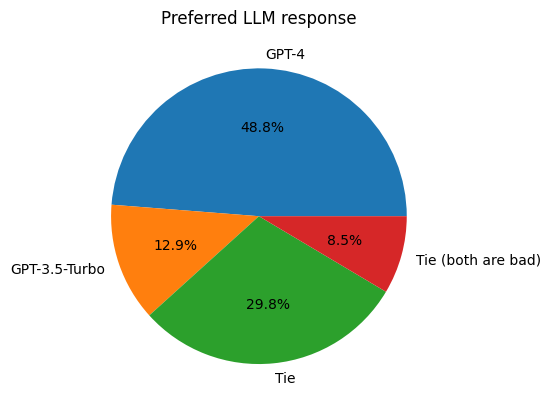

In [421]:
import matplotlib.pyplot as plt

labels = 'GPT-4', 'GPT-3.5-Turbo', 'Tie', 'Tie (both are bad)'
sizes = [gpt_won, gpt35_won, tie, tie_bothbad]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title("Preferred LLM response")